<a href="https://colab.research.google.com/github/ViktorKitanov/CAS_ADS_2023_24/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive & Authenticate Google Big Query Access

In [37]:
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')
auth.authenticate_user()
print('Authenticated')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Authenticated


#Load Packages

In [38]:
#Google Big Query related packages

from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import RobustScaler

#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

fatal: destination path 'CAS_ADS_Final_Project' already exists and is not an empty directory.


##Connect to Big Query and Get Data

In [39]:
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)

Query = "SELECT * FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset`;"
Query_Results = bigquery_client.query(Query)
df = Query_Results.to_dataframe()

#Only Run For Full Dataset Testing (only 20k transactions)

In [45]:
# Reseting the Data Frame
Data_Adf = pd.DataFrame()

# Select subset with non-null & null values
ones_subset = df.loc[df["Chargebackreason_id"].notnull()]
zeros_subset = df.loc[df["Chargebackreason_id"].isnull()]

# Count the number of non-null values & Sample null values to match the number of non-null values
number_of_ones = len(ones_subset)
sampled_zeros = zeros_subset.sample(number_of_ones)

# Concatenate the sampled null values with the non-null values
balanced_df = pd.concat([ones_subset, sampled_zeros], ignore_index=True)

# Order the DataFrame by timestamp & reset index
balanced_df = balanced_df.sort_values(by='timestamp')
balanced_df.reset_index(drop=True, inplace=True)

#Copy Dataset & account for Null Values
Data_Adf = balanced_df.copy()
Data_Adf.replace('<NA>', np.nan, inplace=True)

Data_Adf

,id,transaction_sn,cluster_sn,amount,amount_gbp,ip,processor_timestamp,arn,recurring_sn,dispute_age,...,MCCs_created_at,Accountmanager_id,Accountmanager_name,Accountmanager_updated_at,Accountmanager_created_at,Chargebackreason_id,Chargebackreason_code,Chargebackreason_description,Chargebackreason_updated_at,Chargebackreason_created_at
0,1983485,weh2N2zP,Hl4JIuT4,67.000000000,53.650000000,12.145.236.21,2021-01-01 00:01:09+00:00,None,None,<NA>,...,NaT,<NA>,None,NaT,NaT,45,10,Fraud,2023-06-22 12:56:52+00:00,NaT
1,1983490,cQkOMEaL,ypK23e1u,67.000000000,53.650000000,67.79.75.78,2021-01-01 00:08:22+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,34,4837,No Cardholder Authorization,2023-06-22 12:56:52+00:00,NaT
2,1983500,1QCVtCOS,JLMhl7ZB,77.000000000,61.660000000,174.253.160.26,2021-01-01 00:20:31+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,4,10.4,Other Fraud: Card-absent Environment/Condition,2023-06-22 12:56:52+00:00,NaT
3,1983522,ZFDjNE9B,xmCTKifn,197.000000000,157.750000000,174.253.160.26,2021-01-01 00:37:18+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,4,10.4,Other Fraud: Card-absent Environment/Condition,2023-06-22 12:56:52+00:00,NaT
4,1983524,zg2YiZFC,aCEgIaZn,197.000000000,157.750000000,174.253.160.26,2021-01-01 00:38:51+00:00,None,None,<NA>,...,NaT,28,Ori Levi,2020-04-18 23:08:37+00:00,NaT,4,10.4,Other Fraud: Card-absent Environment/Condition,2023-06-22 12:56:52+00:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21719,11588585,k4c9A61Y,D7fsQpPy,14.990000000,14.990000000,94.7.147.157,2024-04-30 19:29:32+00:00,None,None,<NA>,...,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,<NA>,None,None,NaT,NaT
21720,11588621,f9NLkZTA,S12zPE9w,98.250000000,83.910000000,62.96.92.123,2024-04-30 19:35:22+00:00,None,None,<NA>,...,NaT,<NA>,None,NaT,NaT,<NA>,None,None,NaT,NaT
21721,11588700,A1Fa6DE3,CB6TXBy7,39.990000000,39.990000000,92.10.9.153,2024-04-30 19:45:00+00:00,None,None,<NA>,...,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,<NA>,None,None,NaT,NaT
21722,11588966,21OE7Ofp,P0QV1JJP,29.990000000,29.990000000,194.207.159.61,2024-04-30 20:24:58+00:00,None,None,<NA>,...,NaT,427,Gareth De Klerk,2024-03-27 13:21:07+00:00,NaT,<NA>,None,None,NaT,NaT


In [46]:
# Check for duplicate rows in Data_Adf
duplicate_rows = Data_Adf[Data_Adf.duplicated()]

# Print the duplicate rows, if any
if not duplicate_rows.empty:
    print("Duplicate rows in Data_Adf:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in Data_Adf.")


No duplicate rows found in Data_Adf.


In [48]:
# Checking which dataset is used (full or reduced)
null_count = Data_Adf['Chargebackreason_id'].isnull().sum()
not_null_count = Data_Adf['Chargebackreason_id'].notnull().sum()

print("Number of null transactions in chargebackreason_id:", null_count)
print("Number of non-null transactions in chargebackreason_id:", not_null_count)

Number of null transactions in chargebackreason_id: 10862
Number of non-null transactions in chargebackreason_id: 10862


# Limited to 10k fo Testing Purposes (but we have duplicated values here somehow...)

In [ ]:
# Reseting the Data Frame
Data_Adf = pd.DataFrame()

# Select subset with non-null & null values & sample 5000 each
ones_subset = df.loc[df["Chargebackreason_id"].notnull()]
zeros_subset = df.loc[df["Chargebackreason_id"].isnull()]
sampled_ones = ones_subset.sample(n=5000, replace=True)
sampled_zeros = zeros_subset.sample(n=5000, replace=True)

# Concatenate the sampled null and non-null values
balanced_df = pd.concat([sampled_ones, sampled_zeros], ignore_index=True)

# Order the DataFrame by timestamp & reset index
balanced_df = balanced_df.sort_values(by='timestamp')
balanced_df.reset_index(drop=True, inplace=True)

#Copy Dataset & account for Null Values
Data_Adf = balanced_df.copy()
Data_Adf.replace('<NA>', np.nan, inplace=True)

Data_Adf

In [ ]:
# Check for duplicate rows in Data_Adf
duplicate_rows = Data_Adf[Data_Adf.duplicated()]

# Print the duplicate rows, if any
if not duplicate_rows.empty:
    print("Duplicate rows in Data_Adf:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in Data_Adf.")


In [9]:
# previous code, can be deleted
# project_id = 'total-biplane-387513'
# bigquery_client = bigquery.Client(project = project_id)

# Query = "SELECT * FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` limit 10000;"
# Query_Results = bigquery_client.query(Query)
# df = Query_Results.to_dataframe()
# df

# #Copy Dataset
# Data_Adf = df.copy()

# #Account for Null Values
# Data_Adf.replace('<NA>', np.nan, inplace=True)

#Conversion and Creation of Variables

In [50]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)

#Add Is_fraud Column & make it an integer
Data_Adf['Is_fraud'] = Data_Adf['Chargebackreason_id'].notnull()
Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].astype(int)

#Data Analysis

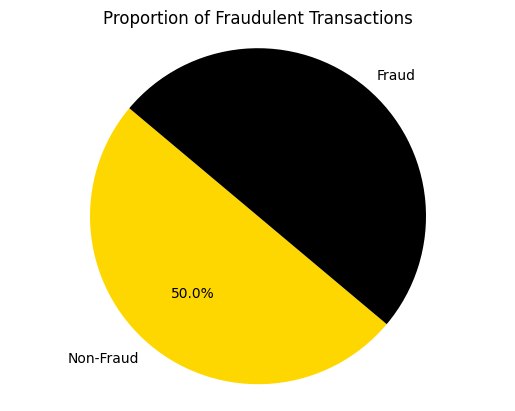

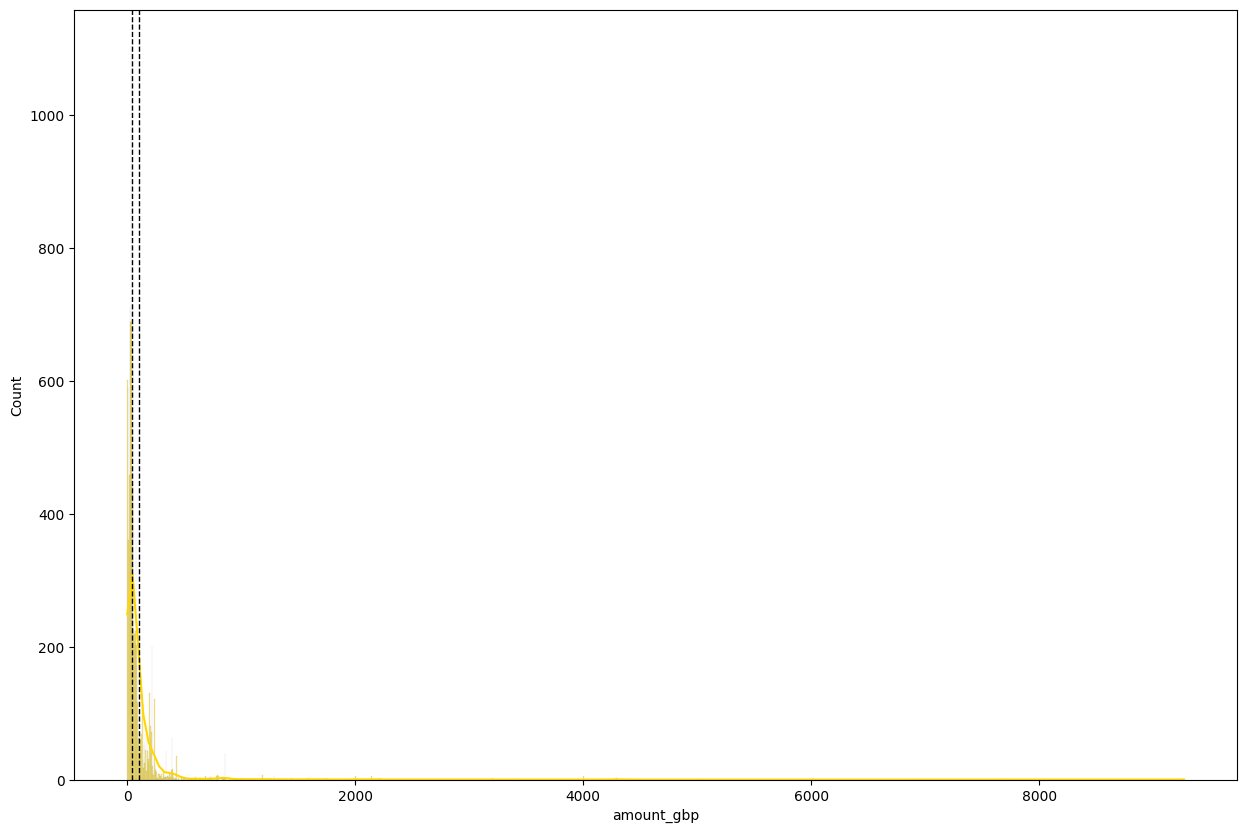

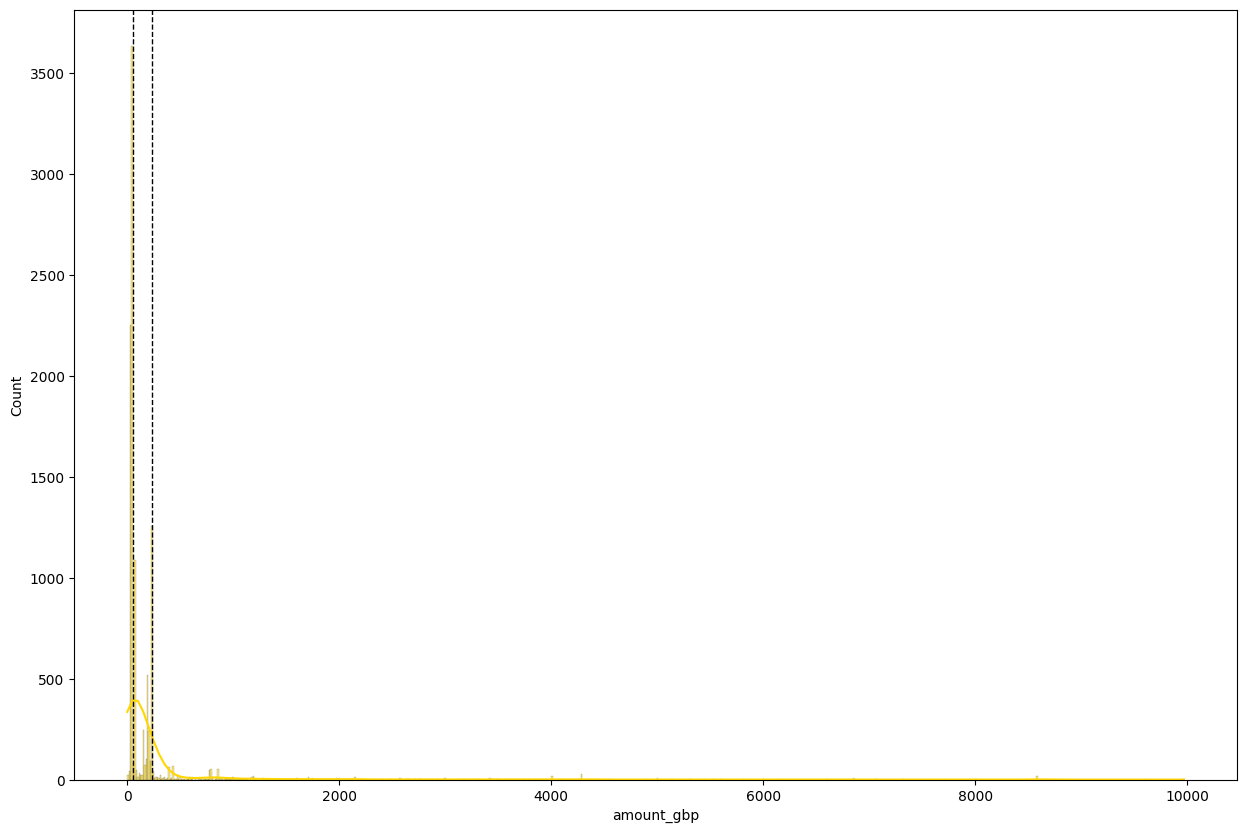

In [51]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [52]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge Datasets to one
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058555,53.65,53.65,1.0
1,1058557,53.65,53.65,1.0
2,1058558,157.75,157.75,1.0
3,1058568,157.75,157.75,1.0
4,1058569,157.75,157.75,1.0
...,...,...,...,...
19866,4642553,53.64,53.64,1.0
19867,4642566,35.00,35.00,1.0
19868,4642718,83.91,83.91,1.0
19869,4642734,39.99,39.99,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [53]:
def get_country(ip):
    # mmdb_file_path = '/content/drive/MyDrive/.../GeoLite2-City.mmdb' #Maayan's source
    mmdb_file_path = '/content/drive/MyDrive/Colab_Notebooks/CAS_Final_Project/GeoLite2-City.mmdb' #Viki's source

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

#df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/.../Country_lan_lat.csv",sep=';') #Maayan's source
df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CAS_Final_Project/Country_lan_lat.csv",sep=';') #Viki's source

In [54]:
#Get Customer Device IP Coordinates (Country)
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]

old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
print(Cust_Country_Profile_Ip)

             id  client_id  latitude_ip  longitude_ip
0       1983485    1058555          NaN           NaN
1       1983490    1058557          NaN           NaN
2       1983500       <NA>          NaN           NaN
3       1983522    1058568          NaN           NaN
4       1983524    1058569          NaN           NaN
...         ...        ...          ...           ...
21719  11588585    3047646    55.378051     -3.435973
21720  11588621    4642718    51.165691     10.451526
21721  11588700    4642734    55.378051     -3.435973
21722  11588966    3234068    55.378051     -3.435973
21723  11589279    4642970    55.378051     -3.435973

[21724 rows x 4 columns]


In [55]:
#Get Customer Card Issuer Bank Coordinates (Country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()
Card_Info_Country_Profile = Card_Info_Country_Profile.fillna(0)
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
print(Card_Info_Country_Profile)

             id  client_id  latitude_card  longitude_card
0       1983485    1058555            NaN             NaN
1       1983490    1058557            NaN             NaN
2       1983500          0            NaN             NaN
3       1983522    1058568            NaN             NaN
4       1983524    1058569            NaN             NaN
...         ...        ...            ...             ...
21719  11588585    3047646      55.378051       -3.435973
21720  11588621    4642718      46.227638        2.213749
21721  11588700    4642734      55.378051       -3.435973
21722  11588966    3234068      55.378051       -3.435973
21723  11589279    4642970      55.378051       -3.435973

[21724 rows x 4 columns]


In [66]:
id_value = 3102565 # we have double or triple (where no chargeback_reason) entries for those id's: 2193738, 2503709, 2612057, 3102565
rows_with_id_value = Data_Adf[Data_Adf['id'] == id_value]
print("Rows with id value", id_value, "in Cust_Country_Profile_Ip:")
print(rows_with_id_value)

# Show the content of the id column with the value 1983772 in Card_Info_Country_Profile
rows_with_id_value = Data_Adf[Data_Adf['id'] == id_value]
print("\nRows with id value", id_value, "in Card_Info_Country_Profile:")
print(rows_with_id_value)

Rows with id value 3102565 in Cust_Country_Profile_Ip:
           id transaction_sn cluster_sn         amount  amount_gbp  \
8021  3102565       ymDUDXko   aBzloevQ  250.000000000      197.82   
8022  3102565       ymDUDXko   aBzloevQ  250.000000000      197.82   

                 ip processor_timestamp   arn recurring_sn  dispute_age  ...  \
8021  212.3.196.172                 NaT  None         None         <NA>  ...   
8022  212.3.196.172                 NaT  None         None         <NA>  ...   

     Accountmanager_id Accountmanager_name  Accountmanager_updated_at  \
8021                23          Hai Shmool  2020-04-18 23:08:37+00:00   
8022                23          Hai Shmool  2020-04-18 23:08:37+00:00   

     Accountmanager_created_at  Chargebackreason_id Chargebackreason_code  \
8021                       NaT                   48                    13   
8022                       NaT                   20                  13.5   

     Chargebackreason_description Chargeb

In [67]:
#Customer Country Coordinates (Final)
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,on='id')

merge_df.columns
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns

old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
print(Cust_Country_Profile)

          client_id  latitude_ip  longitude_ip  latitude_card  longitude_card
id                                                                           
1983485     1058555          NaN           NaN            NaN             NaN
1983490     1058557          NaN           NaN            NaN             NaN
1983500        <NA>          NaN           NaN            NaN             NaN
1983522     1058568          NaN           NaN            NaN             NaN
1983524     1058569          NaN           NaN            NaN             NaN
...             ...          ...           ...            ...             ...
11588585    3047646    55.378051     -3.435973      55.378051       -3.435973
11588621    4642718    51.165691     10.451526      46.227638        2.213749
11588700    4642734    55.378051     -3.435973      55.378051       -3.435973
11588966    3234068    55.378051     -3.435973      55.378051       -3.435973
11589279    4642970    55.378051     -3.435973      55.378051   

# Get Transaction Profile (Trx_Profile)

In [68]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def is_weekend(date):
    return date.weekday() >= 5

def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)


columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}

Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
1983485,2021-01-01 00:01:07+00:00,1058555,53.65,67,0,0
1983490,2021-01-01 00:08:21+00:00,1058557,53.65,501,0,0
1983500,2021-01-01 00:20:30+00:00,<NA>,61.66,1230,0,0
1983522,2021-01-01 00:37:17+00:00,1058568,157.75,2237,0,0
1983524,2021-01-01 00:38:50+00:00,1058569,157.75,2330,0,0
...,...,...,...,...,...,...
11588585,2024-04-30 19:29:35+00:00,3047646,14.99,70175,0,0
11588621,2024-04-30 19:35:23+00:00,4642718,83.91,70523,0,0
11588700,2024-04-30 19:45:01+00:00,4642734,39.99,71101,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [69]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 1min 39s, sys: 1.7 s, total: 1min 41s
Wall time: 1min 41s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1983485,2021-01-01 00:01:07,1058555,53.65,1.0,53.65,1.0,53.65,1.0,53.65
1983490,2021-01-01 00:08:21,1058557,53.65,1.0,53.65,1.0,53.65,1.0,53.65
2006281,2021-01-05 10:54:33,1058558,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983522,2021-01-01 00:37:17,1058568,157.75,1.0,157.75,1.0,157.75,1.0,157.75
1983524,2021-01-01 00:38:50,1058569,157.75,1.0,157.75,1.0,157.75,1.0,157.75
...,...,...,...,...,...,...,...,...,...
11588273,2024-04-30 18:44:28,4642553,53.64,1.0,53.64,1.0,53.64,1.0,53.64
11588545,2024-04-30 19:25:11,4642566,35.00,1.0,35.00,1.0,35.00,1.0,35.00
11588621,2024-04-30 19:35:23,4642718,83.91,1.0,83.91,1.0,83.91,1.0,83.91


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [70]:
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].astype(bool)
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

Brand_Fraud_Profile.set_index('id')

Brand_Fraud_Profile

Brand_Fraud_Profile.set_index('id',inplace=True)

Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

Brand_Fraud_Profile

CPU times: user 1.27 s, sys: 10.5 ms, total: 1.28 s
Wall time: 1.28 s


,timestamp,Brands_id,amount_gbp_fraud_trx,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,,
1983976,2021-01-01 09:09:44,1234,37.64,1.0,37.64,1.0,37.640000,1.0,37.640000
1989686,2021-01-02 18:18:00,1234,53.65,1.0,53.65,2.0,45.645000,2.0,45.645000
1999498,2021-01-04 21:42:57,1234,157.75,1.0,157.75,3.0,83.013333,3.0,83.013333
2103691,2021-01-06 21:50:25,1234,45.64,1.0,45.64,4.0,73.670000,4.0,73.670000
2119649,2021-01-08 17:33:31,1234,NaN,0.0,NaN,3.0,85.680000,4.0,73.670000
...,...,...,...,...,...,...,...,...,...
11288353,2024-03-30 13:36:46,851563,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11401217,2024-04-10 08:36:33,851563,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11466354,2024-04-16 22:36:05,851566,NaN,0.0,NaN,0.0,NaN,0.0,NaN


# Get All Dummy Variables (Data_Dummies)

In [71]:
# creating a copy of the original data frame and adding a few columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating all dummy variables
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_EUR,Currency_name_GBP,Currency_name_INR,Currency_name_RUB,Currency_name_USD,Currency_name_ZAR,Environments_name_PrestaShop,...,Companies_name_Zorafin_Investments_Ltd,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
1983485,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1983490,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1983500,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1983522,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1983524,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11588585,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
11588621,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
11588700,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Combine Everything to a Single Dataset

In [73]:
# Rest indexs in all dataframes in preparation to merge
Cust_Profiles #Key is Client id
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id
Data_Dummies = Data_Dummies.reset_index(level='id') #Key is id

In [85]:
#Merge all datasets to a single dataset
DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag['id'] = DF_Flag['id'].astype(int)
DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
DF['Is_fraud'] = DF['Is_fraud'].astype(int)
print("---------------------------------------DF---------------------------------------")
print("Number of rows in DF:", DF.shape[0])
print(DF.head(3))
DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
print("---------------------------------------DF1---------------------------------------")
print("Number of rows in DF:", DF1.shape[0])
print(DF1.head(3))
DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
print("---------------------------------------DF1---------------------------------------")
print("Number of rows in DF:", DF2.shape[0])
print(DF2.head(3))

---------------------------------------DF---------------------------------------
Number of rows in DF: 21748
        id  client_id  latitude_ip  longitude_ip  latitude_card  \
0  1983485    1058555          NaN           NaN            NaN   
1  1983490    1058557          NaN           NaN            NaN   
2  1983500       <NA>          NaN           NaN            NaN   

   longitude_card  Is_fraud  
0             NaN         1  
1             NaN         1  
2             NaN         1  
---------------------------------------DF1---------------------------------------
Number of rows in DF: 21780
        id  client_id_x  latitude_ip  longitude_ip  latitude_card  \
0  1983485      1058555          NaN           NaN            NaN   
1  1983490      1058557          NaN           NaN            NaN   
2  1983500         <NA>          NaN           NaN            NaN   

   longitude_card  Is_fraud                 timestamp  client_id_y  \
0             NaN         1 2021-01-01 00:01:

<ipython-input-85-a8ee986c99f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Flag['id'] = DF_Flag['id'].astype(int)


In [86]:
DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')
print("---------------------------------------DF1---------------------------------------")
print("Number of rows in DF:", DF3.shape[0])
print(DF3.head(3))

---------------------------------------DF1---------------------------------------
Number of rows in DF: 21972
        id  client_id_x  latitude_ip  longitude_ip  latitude_card  \
0  1983485      1058555          NaN           NaN            NaN   
1  1983490      1058557          NaN           NaN            NaN   
2  1983500         <NA>          NaN           NaN            NaN   

   longitude_card  Is_fraud               timestamp_x  client_id_y  \
0             NaN         1 2021-01-01 00:01:07+00:00      1058555   
1             NaN         1 2021-01-01 00:08:21+00:00      1058557   
2             NaN         1 2021-01-01 00:20:30+00:00         <NA>   

   trx_amount_gbp  ...  client_avg_amount_30day_window           timestamp  \
0           53.65  ...                           53.65 2021-01-01 00:01:07   
1           53.65  ...                           53.65 2021-01-01 00:08:21   
2           61.66  ...                             NaN 2021-01-01 00:20:30   

   Brands_id amount

In [87]:
DF4 = pd.merge(DF3, Data_Dummies, how='left', on='id')
print("---------------------------------------DF1---------------------------------------")
print("Number of rows in DF:", DF4.shape[0])
print(DF4.head(3))

---------------------------------------DF1---------------------------------------
Number of rows in DF: 22228
        id  client_id_x  latitude_ip  longitude_ip  latitude_card  \
0  1983485      1058555          NaN           NaN            NaN   
1  1983490      1058557          NaN           NaN            NaN   
2  1983500         <NA>          NaN           NaN            NaN   

   longitude_card  Is_fraud               timestamp_x  client_id_y  \
0             NaN         1 2021-01-01 00:01:07+00:00      1058555   
1             NaN         1 2021-01-01 00:08:21+00:00      1058557   
2             NaN         1 2021-01-01 00:20:30+00:00         <NA>   

   trx_amount_gbp  ...  Companies_name_Zorafin_Investments_Ltd  \
0           53.65  ...                                       0   
1           53.65  ...                                       0   
2           61.66  ...                                       1   

   Companies_name_xShop_OU  Processors_name_CCD Processors_name_CTM

In [88]:
DF5 = pd.merge(DF4, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')
print("---------------------------------------DF1---------------------------------------")
print("Number of rows in DF:", DF5.shape[0])
print(DF5.head(3))

---------------------------------------DF1---------------------------------------
Number of rows in DF: 22228
        id  client_id_x  latitude_ip  longitude_ip  latitude_card  \
0  1983485      1058555          NaN           NaN            NaN   
1  1983490      1058557          NaN           NaN            NaN   
2  1983500         <NA>          NaN           NaN            NaN   

   longitude_card  Is_fraud               timestamp_x  client_id_y  \
0             NaN         1 2021-01-01 00:01:07+00:00      1058555   
1             NaN         1 2021-01-01 00:08:21+00:00      1058557   
2             NaN         1 2021-01-01 00:20:30+00:00         <NA>   

   trx_amount_gbp  ...  Processors_name_ECP  Processors_name_LPB  \
0           53.65  ...                    0                    0   
1           53.65  ...                    0                    0   
2           61.66  ...                    0                    0   

   Processors_name_NUV Processors_name_PNC  Processors_name

In [89]:
#Merge all datasets to a single dataset
# DF_Flag = Data_Adf[['id', 'Is_fraud']]
# DF_Flag['id'] = DF_Flag['id'].astype(int)
# DF = pd.merge(Cust_Country_Profile, DF_Flag, how='left', on='id')
# DF1 = pd.merge(DF, Trx_Profile, how='left', on='id')
# DF2 = pd.merge(DF1, Trx_Profile_Rolling,how='left',on='id')
# DF3 = pd.merge(DF2, Brand_Fraud_Profile,how='left',on='id')
# DF4 = pd.merge(DF3, Data_Dummies, how='left', on='id')
# DF5 = pd.merge(DF4, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

#Create New Dataframe
Pre_Norm_DF = DF5
#Gather columns containing Ids
column_ids = [col for col in Pre_Norm_DF.columns if '_id' in col]
#column_ids.remove('Email_domain_idtech')
column_timestamp = [col for col in Pre_Norm_DF.columns if 'timestamp' in col]
columns_amount = [col for col in Pre_Norm_DF.columns if 'amount' in col]

#Drop unnecessary columns
dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

Pre_Norm_DF = Pre_Norm_DF.drop(columns = dropcolumns)
Pre_Norm_DF


,latitude_ip,longitude_ip,latitude_card,longitude_card,Is_fraud,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,NaN,NaN,NaN,NaN,1,67,0,0,53.65,1.0,...,0,0,0,0,0,0,0,53.65,53.65,1.0
1,NaN,NaN,NaN,NaN,1,501,0,0,53.65,1.0,...,0,0,0,0,0,0,1,53.65,53.65,1.0
2,NaN,NaN,NaN,NaN,1,1230,0,0,NaN,NaN,...,0,0,0,0,0,0,1,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1,2237,0,0,157.75,1.0,...,0,0,0,0,0,0,1,157.75,157.75,1.0
4,NaN,NaN,NaN,NaN,1,2330,0,0,157.75,1.0,...,0,0,0,0,0,0,1,157.75,157.75,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22223,55.378051,-3.435973,55.378051,-3.435973,0,70175,0,0,14.99,1.0,...,0,1,0,0,0,0,0,14.99,14.99,1.0
22224,51.165691,10.451526,46.227638,2.213749,0,70523,0,0,83.91,1.0,...,0,0,0,0,0,1,0,83.91,83.91,1.0
22225,55.378051,-3.435973,55.378051,-3.435973,0,71101,0,0,39.99,1.0,...,0,0,0,0,1,0,0,39.99,39.99,1.0
22226,55.378051,-3.435973,55.378051,-3.435973,0,73500,0,0,29.99,1.0,...,0,1,0,0,0,0,0,22.49,22.49,1.0


# Extract Target Variable



In [90]:
# Extract target variable and drop unnecessary columns
y = Pre_Norm_DF['Is_fraud']
X = Pre_Norm_DF.drop(columns=['Is_fraud'])

# Replace NaN with zeroes
X = X.fillna(0)

In [91]:
X

,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,0.000000,0.000000,0.000000,0.000000,67,0,0,53.65,1.0,53.65,...,0,0,0,0,0,0,0,53.65,53.65,1.0
1,0.000000,0.000000,0.000000,0.000000,501,0,0,53.65,1.0,53.65,...,0,0,0,0,0,0,1,53.65,53.65,1.0
2,0.000000,0.000000,0.000000,0.000000,1230,0,0,0.00,0.0,0.00,...,0,0,0,0,0,0,1,0.00,0.00,0.0
3,0.000000,0.000000,0.000000,0.000000,2237,0,0,157.75,1.0,157.75,...,0,0,0,0,0,0,1,157.75,157.75,1.0
4,0.000000,0.000000,0.000000,0.000000,2330,0,0,157.75,1.0,157.75,...,0,0,0,0,0,0,1,157.75,157.75,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22223,55.378051,-3.435973,55.378051,-3.435973,70175,0,0,14.99,1.0,14.99,...,0,1,0,0,0,0,0,14.99,14.99,1.0
22224,51.165691,10.451526,46.227638,2.213749,70523,0,0,83.91,1.0,83.91,...,0,0,0,0,0,1,0,83.91,83.91,1.0
22225,55.378051,-3.435973,55.378051,-3.435973,71101,0,0,39.99,1.0,39.99,...,0,0,0,0,1,0,0,39.99,39.99,1.0
22226,55.378051,-3.435973,55.378051,-3.435973,73500,0,0,29.99,1.0,29.99,...,0,1,0,0,0,0,0,22.49,22.49,1.0


# Logistic Regression Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Random Forest Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = model.predict(X_test_pca)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Neural Network Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize PCA to keep 95% of the variance
pca = PCA(n_components=0.95)

# Fit PCA on the scaled training data and transform both training and test data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test_pca)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))